# Pre-processing after MC-GPU before FRCNN-CAD 
Text borrowed from Marian Qian github repo:
https://github.com/marianqian/cluster_generation_frcnn_cad/blob/master/cluster_generation.ipynb

"After running MC-GPU on the breast phantoms, the preprocess file contains the functions for processing the .RAW MC-GPU output files and places them inside /post_images folder. MC-GPU outputs of the examples of breast phantoms created above are in the /mcgpu_output folder, and post-processing images for those examples are also located in the /post_images folder.

Processing code was modified from code written by Dr. Kenny Cha."

Note: This code needs to be amended for use with Python3. This is necessary as Python 2.7 reached the end of its life Jan 1 2020, and pip 21.0 dropped support for Python 2.7 Jan 2021. 

In [1]:
import numpy as np
import random as rand
import math
from PIL import Image
from skimage import exposure
from preprocessing import * #File in this repo
import matplotlib.pyplot as plt

#Listing paths
from os import listdir
from os.path import isfile, join
import pathlib

#!pip install -U matplotlib 


Process all images in directory

In [2]:
myPath = '/opt/images/preproc_mass/texture/'
onlyFiles = [f for f in listdir(myPath) if isfile(join(myPath, f))]
outPath = '/opt/images/postproc_mass/texture/'
other=4000000
lower=25
upper=100

print(onlyFiles)

['SameMass_15_CylinderTexture3cm_322_1.7e11_mass1.06.raw', 'SameSpicMaligTestMass5_1740x2415x1140_array0_density1.56.raw', 'SameLobMaligTest_1740x2415x1140_array0_density1.56.raw', 'SameSpicMaligTestMass4_1740x2415x1140_array0_density1.56.raw', 'SameSpicMaligTestMass10_1740x2415x1140_array0_density1.56.raw', 'SameSpicMaligTestMass10_1740x2415x1140_array0.raw', 'SameSpicMaligTestMass6_1740x2415x1140_array0_density1.56.raw', 'SameSpicMaligTestMass9_1740x2415x1140_array0_density1.56.raw', 'SameSpicMaligTestMass9_1740x2415x1140_array0_density2.05.raw']


In [3]:
currentFile = 'SameLobMaligTest_1740x2415x1140_array0_density1.56.raw'
print(currentFile)
img_name = currentFile[:-4] + '{}' + currentFile[-4:]
print(img_name)
fullFilePath = myPath + currentFile
print(fullFilePath)

SameLobMaligTest_1740x2415x1140_array0_density1.56.raw
SameLobMaligTest_1740x2415x1140_array0_density1.56{}.raw
/opt/images/preproc_mass/texture/SameLobMaligTest_1740x2415x1140_array0_density1.56.raw


9040342.0
157804.0
Raw Image min/max: 
63481.0
10209396.0
Masked Image min/max: 
0.0
3999968.0
Inverted Image min/max: 
1.0
3999969.0


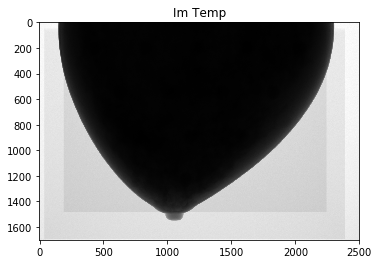

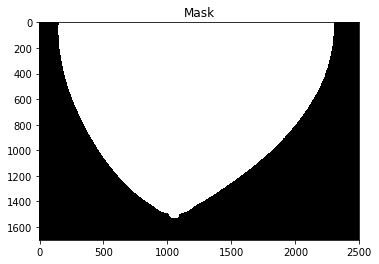

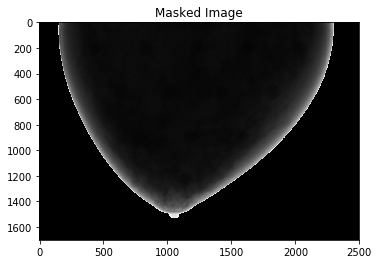

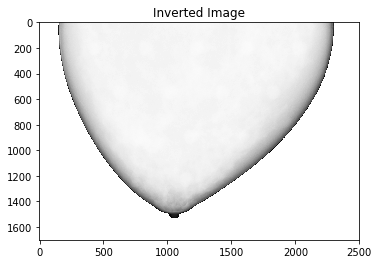

In [4]:
raw = np.fromfile(fullFilePath, dtype='float32', sep="")
image_size = [2]
#image_size.extend((1500, 2000))
image_size.extend((1700, 2500))
raw = raw.reshape(image_size)
print(raw[0,1,1])
print(raw[0,1000,1000])


im_temp = raw[0, :, :] 
#print(im_temp.shape)
plt.figure()
plt.imshow(im_temp, cmap=plt.cm.gray)
plt.title("Im Temp")
print("Raw Image min/max: ")
print(np.min(im_temp))
print(np.max(im_temp))


# Make image mask
# Finds locations where we want to look at. If values are greater than other (400000), 
#array is replced with False, if not, then replaced with True which are locations we want to look at.     
im_mask= np.less(im_temp, other)
#
plt.figure()
plt.imshow(im_mask, cmap=plt.cm.gray)
plt.title("Mask")

#If false, then replaced with 0.
im_temp = np.multiply(im_temp, im_mask)  
#
plt.figure()
plt.imshow(im_temp, cmap=plt.cm.gray)
plt.title("Masked Image")
print("Masked Image min/max: ")
print(np.min(im_temp))
print(np.max(im_temp))

# Invert the image
im_temp = np.max(im_temp) - im_temp  
im_temp = im_temp + 1
#
plt.figure()
plt.imshow(im_temp, cmap=plt.cm.gray)
plt.title("Inverted Image")
print("Inverted Image min/max: ")
print(np.min(im_temp))
print(np.max(im_temp))

log im
0.0
15.2017975


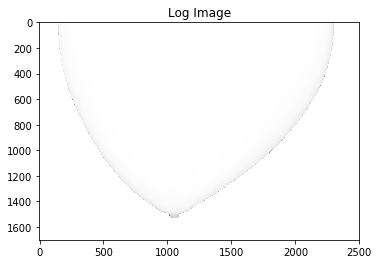

In [5]:
# Take the log of the image
im_log = np.log(im_temp)  
plt.figure()
plt.imshow(im_log, cmap=plt.cm.gray)
plt.title("Log Image")
print('log im')
print(np.min(im_log))
print(np.max(im_log))

Im Temp shift min
0.0
1.201767
0.0
1.1857691


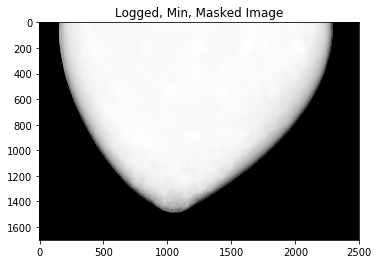

In [6]:
#Get minimum where it is greater than 14 - picks smallest value that is greater than 14 
im_min = np.min(im_log[im_log > 14])

# Perform a shift such that the im_min is 0
im_log_min = im_log - im_min
im_log_min[im_log_min < 0] = 0
print("Im Temp shift min")
print(np.min(im_log_min))
print(np.max(im_log_min))

# Zero out the outside of the images again
im_scaled = np.multiply(im_log_min, im_mask)
plt.figure()
plt.imshow(im_scaled, cmap=plt.cm.gray)
plt.title("Logged, Min, Masked Image")
print(np.min(im_scaled))
print(np.max(im_scaled))

im_temp max:  1.1857691
im_temp min:  0.0
test max:  255.0
test min:  0.0


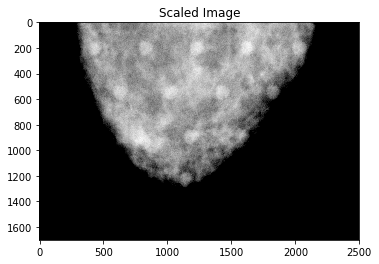

In [7]:
#### Final Steps! Run this section at start of day####
#Zeros out pixels outside of the breast
#im_scaled[im_scaled == np.max(im_scaled)] = 0
print 'im_temp max: ', np.max(im_scaled)
print 'im_temp min: ', np.min(im_scaled)
    
#The value 0.7 can also be changed, but I used 0.7 for all of my pre-processing. 
#Choosing to keep only the pixel values greater than 0.7 and keeping the 25th to 100th percentile values.
#p1, p2 = np.percentile(im_temp[im_temp > 0.2], (lower, upper))
#p1, p2 = np.percentile(im_scaled[im_scaled > 0.30], (25, upper))
p1, p2 = np.percentile(im_scaled[im_scaled > 1.0], (15, 100))

test = exposure.rescale_intensity(im_scaled, in_range=(p1, p2)) * 255
plt.figure()
plt.imshow(test, cmap=plt.cm.gray)
plt.title("Scaled Image")
print 'test max: ', np.max(test)
print 'test min: ', np.min(test)


In [8]:
############# Write out to file #############
    
#img_name = currentFile.name[:-4] + '{}' + currentFile.name[-4:]
addFormat='_full_1.0_15'
imgName = currentFile[:-4] + addFormat
    
#Saving to a RAW file
test.astype('uint8').tofile(outPath+imgName+'_8bit.raw') 
    
#img = Image.frombytes('L', (2000, 1500), test.astype('uint8'))
img = Image.frombytes('L', (2500, 1700), test.astype('uint8'))
    
#Saving to a PNG file.
img.save(outPath+imgName+'_8bit.png') 